In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0180

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - loss: 0.0118
Average validation loss: 0.5840132236480713
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - loss: 0.0118 - val_loss: 0.5840
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - loss: 0.0078 - val_loss: 0.5840
Average validation loss: 0.5590753555297852
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.0078 - val_loss: 0.5715
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.0055 - val_loss: 0.5715
Average validation loss: 0.591244101524353
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - loss: 0.0055 - val_loss: 0.5781
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - loss: 0.0043 - val_loss: 0.5781
Average validation loss: 0.48635

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 821ms/step - loss: 8.2368e-06
Average validation loss: 0.35285304486751556
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 831ms/step - loss: 8.2368e-06 - val_loss: 0.3529
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 821ms/step - loss: 7.2095e-06 - val_loss: 0.3529
Average validation loss: 0.13583990186452866
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 832ms/step - loss: 7.2095e-06 - val_loss: 0.2443
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 807ms/step - loss: 6.7532e-06 - val_loss: 0.2443
Average validation loss: 0.1688995398581028
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 817ms/step - loss: 6.7532e-06 - val_loss: 0.2192
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 777ms/step - loss: 6.4075e-06 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 817ms/step - loss: 1.5221e-06
Average validation loss: 0.11690573891003926
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 827ms/step - loss: 1.5221e-06 - val_loss: 0.1169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 774ms/step - loss: 1.8595e-06 - val_loss: 0.1169
Average validation loss: 0.09148019800583522
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 783ms/step - loss: 1.8595e-06 - val_loss: 0.1042
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step - loss: 1.7201e-06 - val_loss: 0.1042
Average validation loss: 0.0471643079072237
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 780ms/step - loss: 1.7201e-06 - val_loss: 0.0852
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weig

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 834ms/step - loss: 3.1435e-07
Average validation loss: 0.02355481358245015
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 843ms/step - loss: 3.1435e-07 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 813ms/step - loss: 2.8748e-07 - val_loss: 0.0236
Average validation loss: 0.03917040326632559
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 827ms/step - loss: 2.8748e-07 - val_loss: 0.0314
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 793ms/step - loss: 2.6925e-07 - val_loss: 0.0314
Average validation loss: 0.021316632628440857
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 2.6925e-07 - val_loss: 0.0280
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 778ms/step - loss: 2.9949

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 831ms/step - loss: 7.7176e-07
Average validation loss: 0.030358914658427237
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 841ms/step - loss: 7.7176e-07 - val_loss: 0.0304
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 781ms/step - loss: 6.1796e-07 - val_loss: 0.0304
Average validation loss: 0.04359714910387993
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 791ms/step - loss: 6.1796e-07 - val_loss: 0.0370
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 782ms/step - loss: 5.0050e-07 - val_loss: 0.0370
Average validation loss: 0.02869473919272423
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 793ms/step - loss: 5.0050e-07 - val_loss: 0.0342
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 781ms/step - loss: 4.3406

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - loss: 5.8604e-07
Average validation loss: 0.018399629392661154
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 791ms/step - loss: 5.8604e-07 - val_loss: 0.0184
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 830ms/step - loss: 4.7330e-07 - val_loss: 0.0184
Average validation loss: 0.014832319264921049
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 840ms/step - loss: 4.7330e-07 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 780ms/step - loss: 3.9909e-07 - val_loss: 0.0166
Average validation loss: 0.020305220697385568
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 790ms/step - loss: 3.9909e-07 - val_loss: 0.0178
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 790ms/step - loss: 3.42

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - loss: 4.1867e-07
Average validation loss: 0.019064126443117856
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 788ms/step - loss: 4.1867e-07 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 739ms/step - loss: 4.0879e-07 - val_loss: 0.0191
Average validation loss: 0.023012061323970556
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 750ms/step - loss: 4.0879e-07 - val_loss: 0.0210
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 778ms/step - loss: 3.5148e-07 - val_loss: 0.0210
Average validation loss: 0.017971108527854086
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 789ms/step - loss: 3.5148e-07 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 748ms/step - loss: 2.9

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 790ms/step - loss: 2.5606e-07
Average validation loss: 0.012900574676071605
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 802ms/step - loss: 2.5606e-07 - val_loss: 0.0129
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 815ms/step - loss: 2.1981e-07 - val_loss: 0.0129
Average validation loss: 0.01071055163629353
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 827ms/step - loss: 2.1981e-07 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 815ms/step - loss: 1.7775e-07 - val_loss: 0.0118
Average validation loss: 0.009615494151754925
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 827ms/step - loss: 1.7775e-07 - val_loss: 0.0111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 795ms/step - loss: 1.3038e-07
Average validation loss: 0.012988085160031915
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 807ms/step - loss: 1.3038e-07 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 790ms/step - loss: 1.0681e-07 - val_loss: 0.0130
Average validation loss: 0.012484514553632056
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 801ms/step - loss: 1.0681e-07 - val_loss: 0.0127
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 860ms/step - loss: 8.9760e-08 - val_loss: 0.0127
Average validation loss: 0.010590862283217055
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 872ms/step - loss: 8.9760e-08 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0D

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 832ms/step - loss: 7.7608e-08
Average validation loss: 0.01984239832381718
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 843ms/step - loss: 7.7608e-08 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 778ms/step - loss: 7.2813e-08 - val_loss: 0.0198
Average validation loss: 0.01021363993640989
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 790ms/step - loss: 7.2813e-08 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 785ms/step - loss: 6.2265e-08 - val_loss: 0.0150
Average validation loss: 0.014529855325235985
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 796ms/step - loss: 6.2265e-08 - val_loss: 0.0149
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 781ms/step - loss: 6

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 4.9966e-08
Average validation loss: 0.013562640362781368
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 799ms/step - loss: 4.9966e-08 - val_loss: 0.0136
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 4.1514e-08 - val_loss: 0.0136
Average validation loss: 0.0185097156985042
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 802ms/step - loss: 4.1514e-08 - val_loss: 0.0160
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 785ms/step - loss: 3.7153e-08 - val_loss: 0.0160
Average validation loss: 0.013106750486056425
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 796ms/step - loss: 3.7153e-08 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 229s 778ms/step - loss: 3

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 7.4447e-08
Average validation loss: 0.009307972912210971
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 800ms/step - loss: 7.4447e-08 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 807ms/step - loss: 6.0052e-08 - val_loss: 0.0093
Average validation loss: 0.010455108562018723
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 818ms/step - loss: 6.0052e-08 - val_loss: 0.0099
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 856ms/step - loss: 3.1217e-07 - val_loss: 0.0099
Average validation loss: 0.04351056949235499
80/80 ━━━━━━━━━━━━━━━━━━━━ 199s 867ms/step - loss: 3.1217e-07 - val_loss: 0.0211
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 801ms/step - loss: 3.0573e-07 - val_loss: 0.0211
Average validation loss: 0.019782407791353762
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 812ms/step - loss: 3.0573e-07 - val_loss: 0.0208

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 89s 930ms/step - loss: 9.6268e-08
Average validation loss: 0.018341188677974667
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 941ms/step - loss: 9.6268e-08 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 165s 785ms/step - loss: 7.4946e-08 - val_loss: 0.0183
Average validation loss: 0.016240373719483614
96/96 ━━━━━━━━━━━━━━━━━━━━ 166s 795ms/step - loss: 7.4946e-08 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 242s 791ms/step - loss: 6.5945e-08 - val_loss: 0.0173
Average validation loss: 0.018213446407268446
96/96 ━━━━━━━━━━━━━━━━━━━━ 243s 801ms/step - loss: 6.5945e-08 - val_loss: 0.0176
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 320s 801ms/step - los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 3.4291e-07
Average validation loss: 0.018279317650012672
120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 818ms/step - loss: 3.4291e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 792ms/step - loss: 2.5826e-07 - val_loss: 0.0183
Average validation loss: 0.016458718404949953
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 803ms/step - loss: 2.5826e-07 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 793ms/step - loss: 2.0598e-07 - val_loss: 0.0174
Average validation loss: 0.016032025900979838
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 804ms/step - loss: 2.0598e-07 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 807ms/step - loss: 2.2405e-07
Average validation loss: 0.014165468953756822
144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 818ms/step - loss: 2.2405e-07 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 785ms/step - loss: 1.5603e-07 - val_loss: 0.0142
Average validation loss: 0.01757196505786851
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 796ms/step - loss: 1.5603e-07 - val_loss: 0.0159
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 345s 782ms/step - loss: 1.2557e-07 - val_loss: 0.0159
Average validation loss: 0.01823143658596867
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 793ms/step - loss: 1.2557e-07 - val_loss: 0.0167
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 462s 800ms/step - loss: 1.0770e-07 - val_loss: 0.0167
Average validation loss: 0.013737680173815332
144/144 ━━━━━━━━━━━━━━━━━━━━ 463s 811ms/step - loss: 1.0770e-07 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 779ms/step - loss: 6.1620e-08
Average validation loss: 0.014665412751492113
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 791ms/step - loss: 6.1620e-08 - val_loss: 0.0147
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 774ms/step - loss: 5.2354e-08 - val_loss: 0.0147
Average validation loss: 0.014202369717531837
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 785ms/step - loss: 5.2354e-08 - val_loss: 0.0144
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 782ms/step - loss: 4.8101e-08 - val_loss: 0.0144
Average validation loss: 0.016101908590644597
160/160 ━━━━━━━━━━━━━━━━━━━━ 379s 793ms/step - loss: 4.8101e-08 - val_loss: 0.0150
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 508s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 813ms/step - loss: 9.3813e-08
Average validation loss: 0.018740100192371757
200/200 ━━━━━━━━━━━━━━━━━━━━ 165s 824ms/step - loss: 9.3813e-08 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 326s 807ms/step - loss: 7.5181e-08 - val_loss: 0.0187
Average validation loss: 0.0176443577487953
200/200 ━━━━━━━━━━━━━━━━━━━━ 328s 817ms/step - loss: 7.5181e-08 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 784ms/step - loss: 6.4462e-08 - val_loss: 0.0182
Average validation loss: 0.014859409402124584
200/200 ━━━━━━━━━━━━━━━━━━━━ 487s 795ms/step - loss: 6.4462e-08 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 784ms/step - loss: 4.7862e-08
Average validation loss: 0.017231463116574256
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 4.7862e-08 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 777ms/step - loss: 3.9096e-08 - val_loss: 0.0172
Average validation loss: 0.01679649758831753
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 788ms/step - loss: 3.9096e-08 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 568s 783ms/step - loss: 3.6545e-08 - val_loss: 0.0170
Average validation loss: 0.013553688305061465
240/240 ━━━━━━━━━━━━━━━━━━━━ 570s 794ms/step - loss: 3.6545e-08 - val_loss: 0.0159
Saved model weights to 'c:\天_11157065\git\Ripp

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.19231585703790188, 0.10502798147499562, 0.04824274426636596, 0.023955015952233226, 0.022119496402330695, 0.01403272391335728, 0.013265114564681425, 0.010096749989509895, 0.00920786767299952, 0.009676406405487796, 0.010074942524208583, 0.01100126310539781, 0.013739455941298122, 0.01399147465561206, 0.013455788033089547, 0.012913438089533885, 0.015070369117663358, 0.013813689735119017]
std_val_losses =  [0.13496326457746952, 0.06351594941636478, 0.027952277586543322, 0.009216140069309944, 0.010238654978122158, 0.006131638276854144, 0.004756292643448435, 0.002597902863686187, 0.0026028953185525754, 0.004324636545071003, 0.002599361099144636, 0.0054453574240107445, 0.009892791946496548, 0.003320113794967016, 0.0023469127810358055, 0.0019200200976228431, 0.002624488494678775, 0.0020729106798175138]


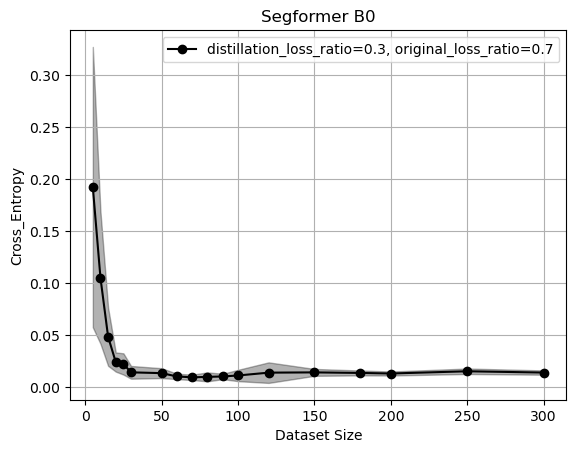

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()